## Importing Libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Scikit libraries
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer


## Reading Data

In [2]:
train_data = pd.read_csv('twitter_training.csv',header=None)

In [3]:
test_data = pd.read_csv('twitter_validation.csv',header=None)

In [4]:
len(train_data)

74682

In [5]:
len(test_data)

1000

In [6]:
train_data.columns

Int64Index([0, 1, 2, 3], dtype='int64')

In [7]:
train_data = train_data.rename(columns={0:'tweetID',1:'Entity',2:'Sentiment',3:'Tweet'})

In [8]:
train_data.columns

Index(['tweetID', 'Entity', 'Sentiment', 'Tweet'], dtype='object')

In [9]:
train_data.head()

,tweetID,Entity,Sentiment,Tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [10]:
test_data.columns

Int64Index([0, 1, 2, 3], dtype='int64')

In [11]:
test_data = test_data.rename(columns={0:'tweetID',1:'Entity',2:'Sentiment',3:'Tweet'})

In [12]:
test_data.head()

,tweetID,Entity,Sentiment,Tweet
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


## EDA

#### Understanding Distribution of Entities

In [13]:
entities_distribution = train_data.Entity.value_counts()

In [14]:
entities_distribution = entities_distribution.reset_index()

In [15]:
entities_distribution = entities_distribution.rename(columns={'index':'Entity','Entity':'Occurances'})

In [16]:
entities_distribution

,Entity,Occurances
0,TomClancysRainbowSix,2400
1,Microsoft,2400
2,MaddenNFL,2400
3,CallOfDuty,2394
4,LeagueOfLegends,2394
5,Verizon,2382
6,CallOfDutyBlackopsColdWar,2376
7,ApexLegends,2376
8,Facebook,2370
9,Dota2,2364


Seems like the data distribution across the entities is well balanced

#### Checking for data imbalance

In [17]:
train_data['Sentiment'].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

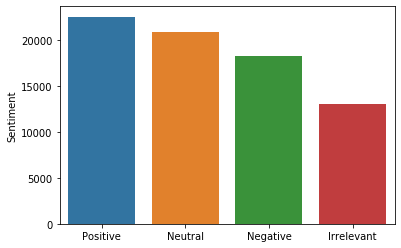

In [18]:
sns.barplot(x=train_data['Sentiment'].unique(), y=train_data['Sentiment'].value_counts())

Data is pretty well balanced.

## Data Preprocessing

In [19]:
train_data[train_data['tweetID']==2401]['Tweet'][3]

'im coming on borderlands and i will murder you all,'

In [20]:
nltk.download('wordnet')
nltk.download('stopwords')
tokenizer = RegexpTokenizer(r'\w+')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\suramsow\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\suramsow\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
stop_words = [i.lower() for i in set(stopwords.words('English'))]

In [22]:
def preprocess_text(txt):
    txt = str(txt)
    txt_list = tokenizer.tokenize(txt)
    txt_list_lower = ' '.join(word.lower() for word in txt_list)
    stop_words_removed = ','.join([word for word in txt_list_lower.split() if word not in stop_words])
    return stop_words_removed

In [23]:
train_data['Tweet'] = train_data['Tweet'].astype(str)
test_data['Tweet'] = test_data['Tweet'].astype(str)

In [24]:
train_data['Text'] = train_data['Tweet'].apply(lambda txt: preprocess_text(txt))
test_data['Text'] = test_data['Tweet'].apply(lambda txt: preprocess_text(txt))

In [25]:
train_data['Text']

0                            im,getting,borderlands,murder
1                                      coming,borders,kill
2                              im,getting,borderlands,kill
3                             im,coming,borderlands,murder
4                          im,getting,borderlands,2,murder
                               ...                        
74677    realized,windows,partition,mac,like,6,years,be...
74678    realized,mac,window,partition,6,years,behind,n...
74679    realized,windows,partition,mac,6,years,behind,...
74680    realized,windows,partition,mac,like,6,years,be...
74681    like,windows,partition,mac,like,6,years,behind...
Name: Text, Length: 74682, dtype: object

In [26]:
encoder = LabelEncoder()
yy_train = encoder.fit_transform(train_data['Sentiment'])
yy_test = encoder.fit_transform(test_data['Sentiment'])
print(np.unique(yy_train))

[0 1 2 3]


In [27]:
X_train, y_train, X_test, y_test = train_data['Text'], yy_train, test_data['Text'], yy_test

#### Vectorization

In [28]:
tfidfVectorizer = TfidfVectorizer()
tfidf_train = tfidfVectorizer.fit_transform(X_train)

In [29]:
tfidf_test = tfidfVectorizer.transform(X_test)


In [30]:
tfidf_train.shape

(74682, 30922)

In [31]:
tfidf_test.shape

(1000, 30922)

## Model

In [32]:
lr = LogisticRegression(random_state=100)

In [33]:
lr_model = lr.fit(tfidf_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [34]:
predictions_train = lr.predict(tfidf_train)

In [36]:
predictions_test = lr.predict(tfidf_test)

## Evaluation

#### Model evaluation on training data

In [39]:
confusion_matrix(y_train,predictions_train)

array([[ 9929,  1178,   700,  1183],
       [  265, 20381,   841,  1055],
       [  323,  1790, 14833,  1372],
       [  351,  1735,   858, 17888]], dtype=int64)

In [40]:
accuracy_score(y_train,predictions_train)

0.8439918588147077

#### Model evaluation on test data

In [41]:
confusion_matrix(y_test,predictions_test)

array([[143,  10,   6,  13],
       [  2, 253,   4,   7],
       [  4,  19, 252,  10],
       [  3,  10,  10, 254]], dtype=int64)

In [42]:
accuracy_score(y_test,predictions_test)

0.902

### Using GridSearchCV